<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/part11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Birds Eye view of LLM

After learning about the attention mechanism, let us learn about the LLM architecture now.

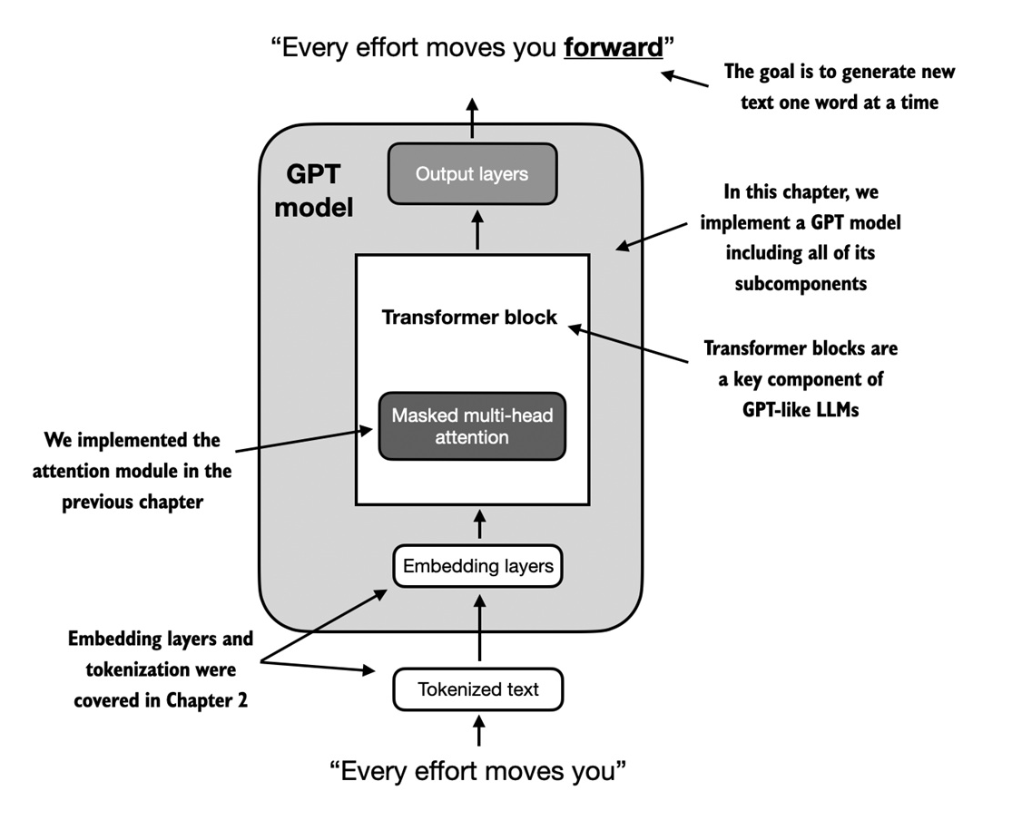

What we have learnt so far:
- input tokenization
- embedding (token + positional)
- maskd multi-head attention

What we are yet to learn:
- Transfer blocks
- scale upto the size of a small GPT-2 model (124 million parameters)

Why GPT-2? \
Open AI has made GPT-2 weights public. GPT-3,4 weights have not yet been made public.

we will build a GPT placeholder architecture. This will give us a bird eye view of how everything fits together.

### Implementing a gpt model from scratch to generate text

In [44]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

Step 1: Use a placeholder for TransformerBlock

Step 2: Use a placeholder for LayerNorm

In [45]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        print("token embedding shape: ", tok_embeds.shape)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        print("position embedding shape: " ,pos_embeds.shape)
        x = tok_embeds + pos_embeds

        # dropout helps in generalization and avoid overfitting
        x = self.drop_emb(x)
        x = self.trf_blocks(x)

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

### STEP 1: TOKENIZATION

In [46]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### STEP 2: CREATE AN INSTANCE OF DUMMYGPTMODEL

In [47]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

token embedding shape:  torch.Size([2, 4, 768])
position embedding shape:  torch.Size([4, 768])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


### output logit

txt1 = "Every effort moves you" forward

output logit will be - (tokens x vocab size) = (4 x 50257) size matrix.

so for suppose first raw -> every

every -> [0, 1, ...., 50256] and prob value for "effort" token will be the hightest.

for second raw

effort -> prob value for "moves" token will be the highest.

...

you -> prob value for "forward" token will be the highest.